# EDA Notebook

This notebook is used to explore the data and understand through some graphs of categories and numerical characteristics and at the end to verify the importance of the characteristics with SHAP. SHAP values are the most mathematically consistent way to get resource importances and work particularly well with tree-based models.

## 1. Importing libraries

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders import CatBoostEncoder
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.creation import CombineWithReferenceFeature
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_recall_curve,
    roc_auc_score,
    plot_roc_curve,
)
import shap
import warnings

# Config
%matplotlib inline
%load_ext nb_black
%load_ext lab_black
pd.set_option("display.max_columns", None)
warnings.filterwarnings("ignore")
shap.initjs()

/home/bobcasta/.churnenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<IPython.core.display.Javascript object>

## 2.1 Loading data

In [2]:
# Load train and test data
df_train = pd.read_csv("../data/interim/train.csv")
df_test = pd.read_csv("../data/interim/test.csv")

<IPython.core.display.Javascript object>

In [3]:
df_train.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4950-BDEUX,Male,0,No,No,35,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65,No
1,7993-NQLJE,Male,0,Yes,Yes,15,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55,No
2,7321-ZNSLA,Male,0,Yes,Yes,13,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35,No
3,4922-CVPDX,Female,0,Yes,No,26,Yes,No,DSL,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.7,No
4,2903-YYTBW,Male,0,Yes,Yes,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55,No


<IPython.core.display.Javascript object>

## 2.2 Checking data

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5634 entries, 0 to 5633
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   PhoneService      5634 non-null   object 
 7   MultipleLines     5634 non-null   object 
 8   InternetService   5634 non-null   object 
 9   OnlineSecurity    5634 non-null   object 
 10  OnlineBackup      5634 non-null   object 
 11  DeviceProtection  5634 non-null   object 
 12  TechSupport       5634 non-null   object 
 13  StreamingTV       5634 non-null   object 
 14  StreamingMovies   5634 non-null   object 
 15  Contract          5634 non-null   object 
 16  PaperlessBilling  5634 non-null   object 


<IPython.core.display.Javascript object>

In [5]:
# Check quantity of rows and columns
print("Quantidade de Linhas: ", df_train.shape[0])
print("Quantidade de Colunas: ", df_train.shape[1])

Quantidade de Linhas:  5634
Quantidade de Colunas:  21


<IPython.core.display.Javascript object>

In [6]:
# Check null values
df_train.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

<IPython.core.display.Javascript object>

We can start to see that the train dataset is small, containing only 5634 rows, 21 variables and no *missing* value, and of these 21 variables only 3 are numerical variables.

Let's start looking at an attribute plus exploratory background analysis now for these variable elements, and lastly to study the elemental attributes. We start with the bar chart of the target Churn variable

## 2.3 Target variable

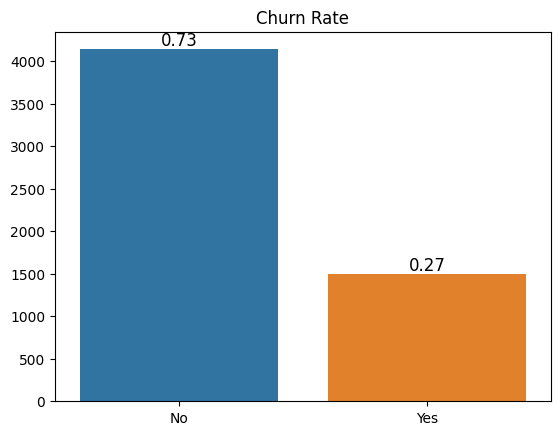

<IPython.core.display.Javascript object>

In [7]:
# Plot target variable
# plt.figure(figsize=(4,3))
ax = sns.barplot(
    x=df_train["Churn"].value_counts().index,
    y=df_train["Churn"].value_counts().values,
    data=df_train,
)

total = float(len(df_train))

for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2.0,
        height,
        "{:1.2f}".format(height / total),
        fontsize=12,
        color="black",
        ha="center",
        va="bottom",
    )

plt.title("Churn Rate")
plt.show()

This plot shows that most of the company's customers did not cancel the contract, about 73%. It is a good result for the company, however, for our model it is something to be corrected, because the variable is unbalanced. We will correct this later, now we will continue the exploratory analysis and cleaning of the other variables.

In [8]:
df_train["Churn"] = df_train["Churn"].map({"Yes": 1, "No": 0})

<IPython.core.display.Javascript object>

## 2.3 Category variables (EDA)

In [9]:
# casting senior citizen to object
df_train["SeniorCitizen"] = df_train["SeniorCitizen"].astype("object")

# casting total charges to float
df_train["TotalCharges"] = df_train["TotalCharges"].apply(
    lambda x: str(x).replace(",", ".")
)
df_train["TotalCharges"] = pd.to_numeric(df_train["TotalCharges"], errors="coerce")
df_train["TotalCharges"] = df_train["TotalCharges"].astype("float64")
df_train["TotalCharges"] = df_train["TotalCharges"].replace(" ", np.nan)

<IPython.core.display.Javascript object>

In [10]:
# Drop customerID
df_train.drop("customerID", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [11]:
# Select only categorical variables
df_train_cat = df_train.select_dtypes(include=["object"])

# Select only numerical variables
df_train_quant = df_train.select_dtypes(exclude=["object"])
df_train_quant.drop("Churn", axis=1, inplace=True)

<IPython.core.display.Javascript object>

In [12]:
df_train_cat.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
count,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634,5634
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,2833,4714,2905,3955,5075,2685,2483,2797,2442,2472,2771,2226,2217,3102,3331,1891


<IPython.core.display.Javascript object>

Most of categorical features have a two or three unique values, so we can use a bar chart to see the distribution of the values. We will use a function to plot the bar chart of each categorical variable.

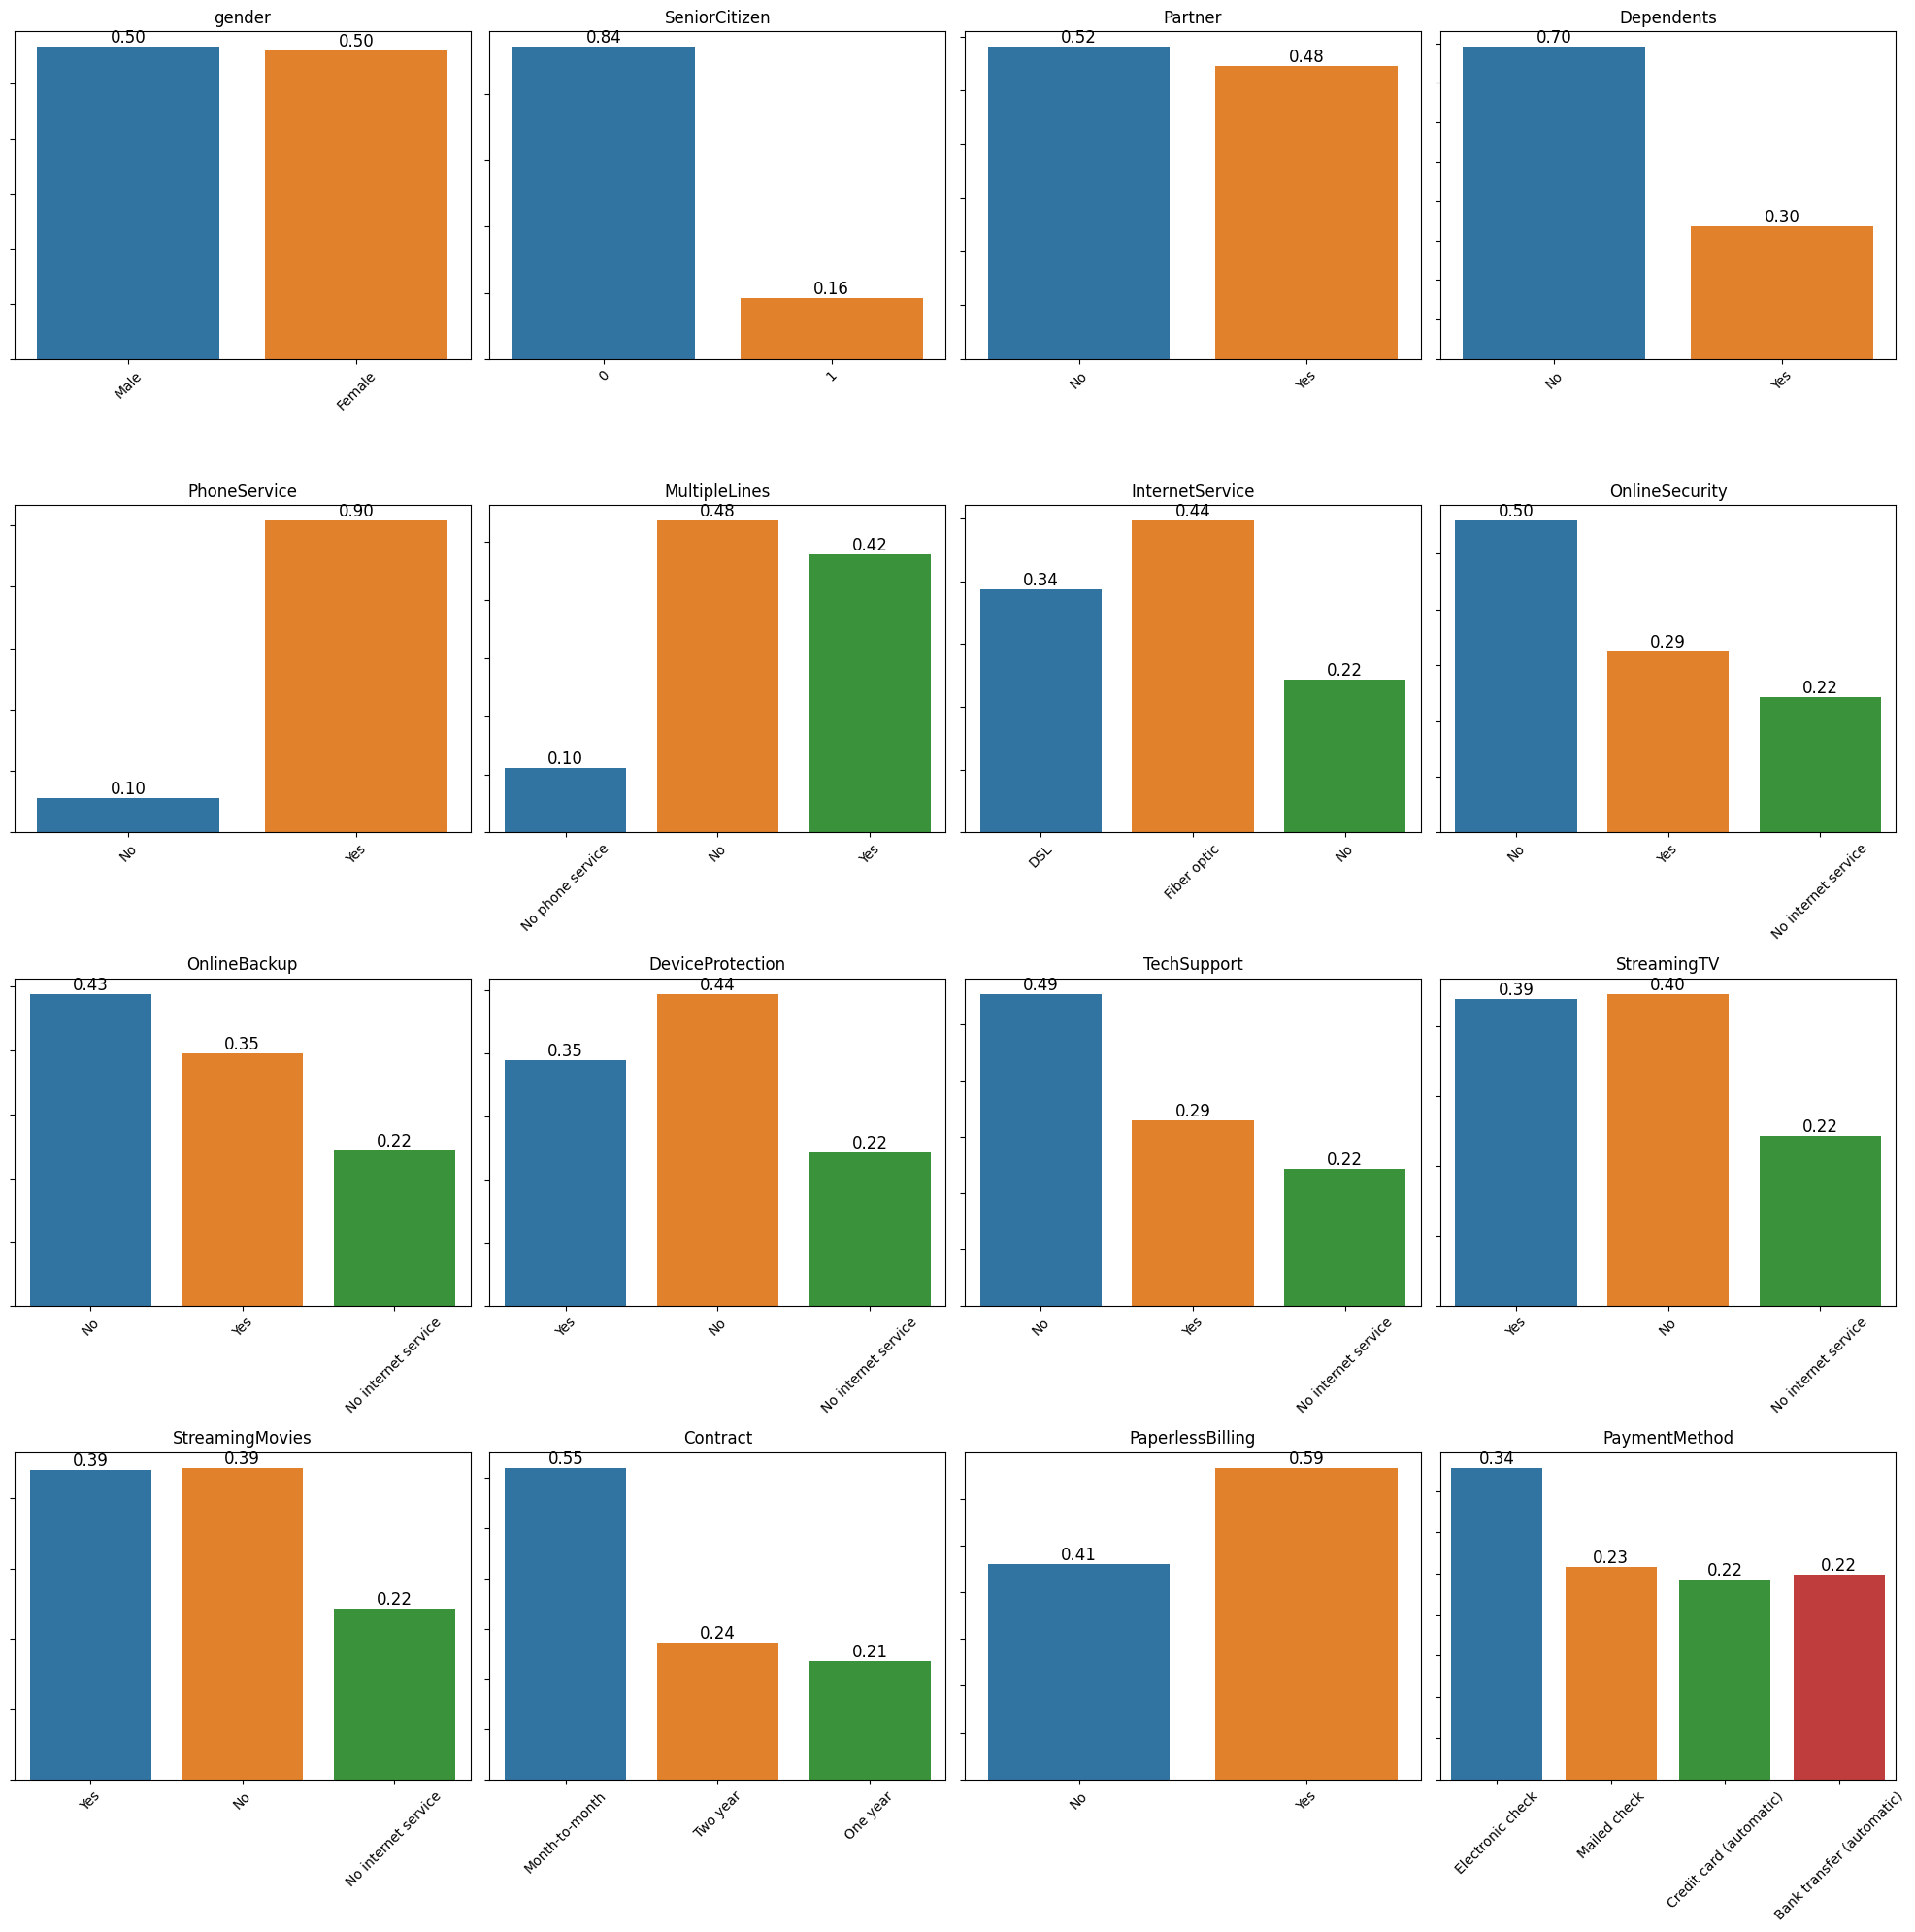

<IPython.core.display.Javascript object>

In [13]:
fig, axes = plt.subplots(3, 3, figsize=(20, 20))
for idx, col in enumerate(df_train_cat):
    ax = plt.subplot(4, 4, idx + 1)
    ax.yaxis.set_ticklabels([])
    sns.countplot(x=col, data=df_train_cat)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    for p in ax.patches:
        height = p.get_height()
        ax.text(
            p.get_x() + p.get_width() / 2.0,
            height,
            "{:1.2f}".format(height / total),
            fontsize=12,
            color="black",
            ha="center",
            va="bottom",
        )
plt.tight_layout()
plt.show()

In [ ]:
# group all categorical variables by churn then plot a horizontal stacked bar chart of the proportions
fig, axes = plt.subplots(4, 4, figsize=(30, 20))
for i, col in enumerate(df_train_cat.columns):
    df_train_cat.groupby([col, df_train["Churn"]]).size().unstack().plot(
        kind="barh", stacked=True, ax=axes[i // 4, i % 4]
    )
    axes[i // 4, i % 4].set_title(col)
    axes[i // 4, i % 4].set_xlabel("")
    axes[i // 4, i % 4].set_ylabel("")
    axes[i // 4, i % 4].set_xticklabels(axes[i // 4, i % 4].get_xticklabels())
plt.tight_layout()
plt.show()

In the two graphs above we can see that most of the categorical characteristics are unbalanced, this is clearer in the stacked bar plot and we need to understand how these variables are really important to predict the target variable.

We can see that in some categorical attributes they have values like "No phone service" and "No internet service" this makes it difficult for both data visualizations and machine learning algorithms.

Instead of keeping these variables with these values, let's replace them with "No" so we can have the data more organized and also when the dummy variables are created in the final dataset it will have a smaller dimension.

## 2.4 Numerical variables (EDA)

In [ ]:
df_train_quant.describe()

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(8, 4))
for idx, col in enumerate(df_train[df_train_quant.columns]):
    ax = plt.subplot(1, 3, idx + 1)
    ax.yaxis.set_ticklabels([])
    sns.distplot(
        df_train.loc[df_train.Churn == 0][col],
        hist=False,
        axlabel=False,
        kde_kws={"linestyle": "-", "label": "Risk"},
    )
    sns.distplot(
        df_train.loc[df_train.Churn == 1][col],
        hist=False,
        axlabel=False,
        kde_kws={"linestyle": "--", "label": "No Risk"},
    )
    ax.set_title(col)

# Mostra o gráfico
plt.tight_layout()
plt.show()

In the histogram below we can see that the numerical variables are not normally distributed, so we will need to normalize them before training some linear machine learning models. We can also see that distribution for clients who have churned is different from those who have not churned for the variables Tenue and MonthlyCharges.

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

for ax, box in zip(axes, df_train[df_train_quant.columns]):
    sns.boxplot(x="Churn", y=box, ax=ax, data=df_train)

# Mostra o gráfico
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes = axes.flatten()

# Itera sobre as variáveis quantitativas para gerar o violin plot
for ax, violin in zip(axes, df_train[df_train_quant.columns]):
    sns.violinplot(x="Churn", y=violin, ax=ax, split=True, data=df_train)

# Mostra o gráfico
plt.show()

With box and violin plots we can see the distribution of the numerical variables for each class of the target variable. We can see these three variables dont have much outliers.

In [ ]:
sns.pairplot(
    df_train,
    vars=df_train[df_train_quant.columns],
    hue="Churn",
    diag_kind="hist",
    corner=True,
    plot_kws=dict(alpha=0.5),
)

plt.tight_layout()
plt.show()

In the pairplot above we can see that the numerical variables are not normally distributed and the variable TotalCharges have a strong possitive relationship with the Tenure and MonthlyCharges variables. For check this relationship we can use a heatmap below.

In [ ]:
sns.heatmap(
    df_train[df_train_quant.columns].corr(method="pearson"),
    annot=True,
    linewidths=0.3,
    square=True,
)

# Mostra o gráfico
plt.show()

## 3.1 Model Pipeline

Now we will create a pipeline to train and test the model. We will use the pipeline to train and test the model with the original dataset and with the dataset. We will use this to check feature importance with SHAP.

In [3]:
X_train = pd.read_csv("../data/interim/train.csv")
X_test = pd.read_csv("../data/interim/test.csv")

<IPython.core.display.Javascript object>

In [ ]:
X_train["Churn"] = X_train["Churn"].map({"Yes": 1, "No": 0})
X_test["Churn"] = X_test["Churn"].map({"Yes": 1, "No": 0})

In [ ]:
def casting_numerical(dataframe, numerical_feature):
    """Cast features to the correct type."""
    dataframe[numerical_feature] = dataframe[numerical_feature].apply(
        lambda dataframe: str(dataframe).replace(",", "."),
    )
    dataframe[numerical_feature] = pd.to_numeric(
        dataframe[numerical_feature], errors="coerce"
    )
    dataframe[numerical_feature] = dataframe[numerical_feature].astype("float64")
    dataframe[numerical_feature] = dataframe[numerical_feature].replace("", np.nan)
    return dataframe


def casting_categorical(dataframe, categorical_feature):
    """Cast features to the correct type."""
    dataframe[categorical_feature] = dataframe[categorical_feature].astype("object")
    return dataframe


def change_no_service_to_no(df):
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].replace("No phone service", "No")
            df[col] = df[col].replace("No internet service", "No")
    return df

In [ ]:
# apply casting_numerical function to X_train and X_test simultaneously
X_train, X_test = map(
    lambda dataframe: casting_numerical(dataframe, "TotalCharges"),
    [X_train, X_test],
)

X_train, X_test = map(
    lambda dataframe: casting_categorical(dataframe, "SeniorCitizen"),
    [X_train, X_test],
)

X_train, X_test = map(
    lambda dataframe: change_no_service_to_no(dataframe),
    [X_train, X_test],
)

In [ ]:
# dropna from X_train and X_test simultaneously
X_train, X_test = map(lambda dataframe: dataframe.dropna(), [X_train, X_test])

In [4]:
y_train = X_train["Churn"]
X_train = X_train.drop("Churn", axis=1)

y_test = X_test["Churn"]
X_test = X_test.drop("Churn", axis=1)

<IPython.core.display.Javascript object>

In [5]:
pipeline = Pipeline(
    [
        ("drop_vars", DropFeatures(["customerID"])),
        (
            "tenure_combine",
            CombineWithReferenceFeature(
                variables_to_combine=["MonthlyCharges", "TotalCharges"],
                reference_variables=["tenure"],
                operations=["div"],
                new_variables_names=["tenureMonthlyRate", "tenureTotalRate"],
            ),
        ),
        (
            "totalcharges_combine",
            CombineWithReferenceFeature(
                variables_to_combine=["TotalCharges"],
                reference_variables=["MonthlyCharges"],
                operations=["div"],
                new_variables_names=["RateCharge"],
            ),
        ),
        (
            "preprocessor",
            ColumnTransformer(
                [
                    (
                        "num",
                        make_pipeline(
                            SimpleImputer(strategy="median"),
                        ),
                        make_column_selector(dtype_include=np.number),
                    ),
                    (
                        "cat",
                        make_pipeline(
                            SimpleImputer(strategy="most_frequent"),
                            TargetEncoder(),
                        ),
                        make_column_selector(dtype_include=["object"]),
                    ),
                ]
            ),
        ),
        ("classifier", XGBClassifier(random_state=42)),
    ]
)

<IPython.core.display.Javascript object>

In [6]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(
    pipeline, X_train, y_train, scoring="roc_auc", cv=cv, n_jobs=-1
)
print("Mean ROC AUC: %.3f" % np.mean(scores), "Std ROC AUC: %.3f" % np.std(scores))

/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
/home/bobcasta/.churnenv/lib/python3.8/

Mean ROC AUC: 0.826 Std ROC AUC: 0.011


<IPython.core.display.Javascript object>